In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler

In [3]:
file_path =  "F:\\Optimising Energy Management in Smart Grids\\Data\\demanddata_2025 (2)(2).csv"  
df = pd.read_csv(file_path)
df.head()


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,...,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
0,2025-01-01,1,21036,26215,19918,5405,6606,0,18720,0,...,-1518,-1026,1,-232,-386,-558,96,0,241,0
1,2025-01-01,2,21222,26063,20167,5358,6606,0,18720,0,...,-1513,-1023,1,-124,-282,-564,51,0,262,0
2,2025-01-01,3,21385,25734,20328,5237,6606,0,18720,0,...,-1428,-922,1,-119,-384,-205,62,0,414,0
3,2025-01-01,4,20473,24988,19460,5115,6606,0,18720,0,...,-1423,-915,0,-119,-334,-193,37,0,423,0
4,2025-01-01,5,19634,24912,18654,5080,6606,0,18720,0,...,-1539,-899,0,-119,-363,-622,-282,0,288,0


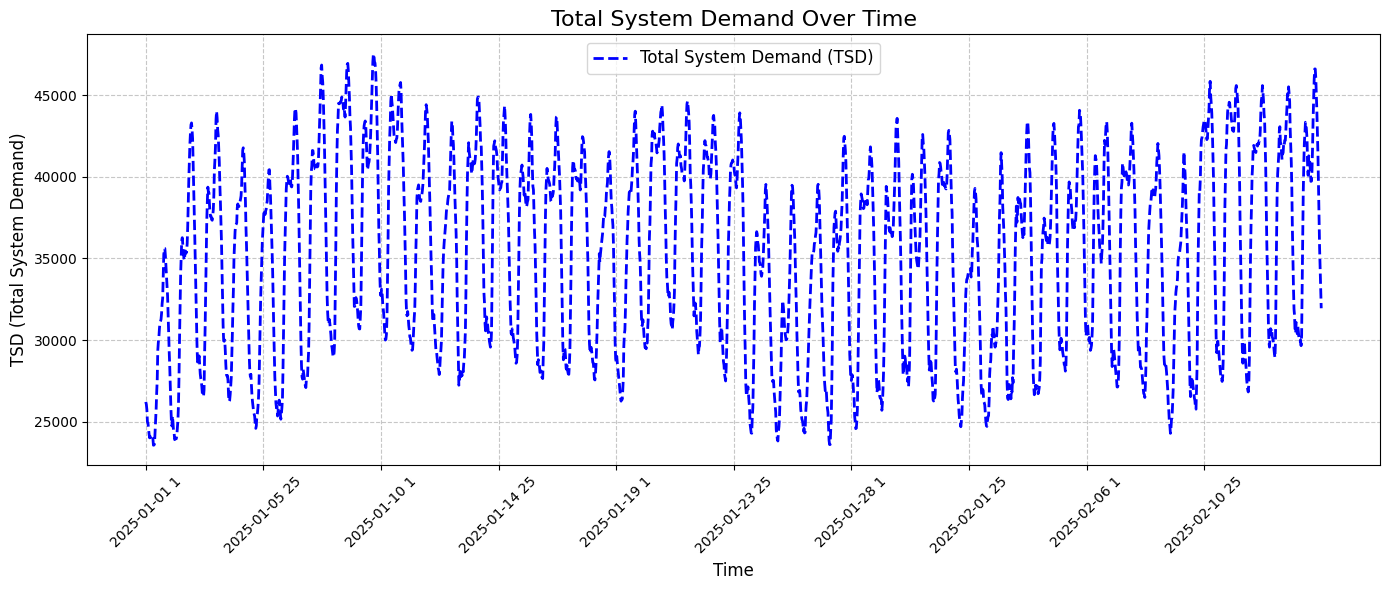

In [6]:
plt.figure(figsize=(14, 6))

# Plotting the data
plt.plot(
    df['SETTLEMENT_DATE'].astype(str) + ' ' + df['SETTLEMENT_PERIOD'].astype(str),
    df['TSD'],
    label='Total System Demand (TSD)',
    color='blue',
    linestyle='--',
    linewidth=2
)

# Customizing x-axis ticks to avoid overlap
plt.xticks(
    ticks=np.arange(0, len(df), step=len(df)//10),  # Show only 10 evenly spaced ticks
    labels=(df['SETTLEMENT_DATE'].astype(str) + ' ' + df['SETTLEMENT_PERIOD'].astype(str))[::len(df)//10],
    rotation=45,
    fontsize=10
)

# Adding titles and labels
plt.title('Total System Demand Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('TSD (Total System Demand)', fontsize=12)

# Adding grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()

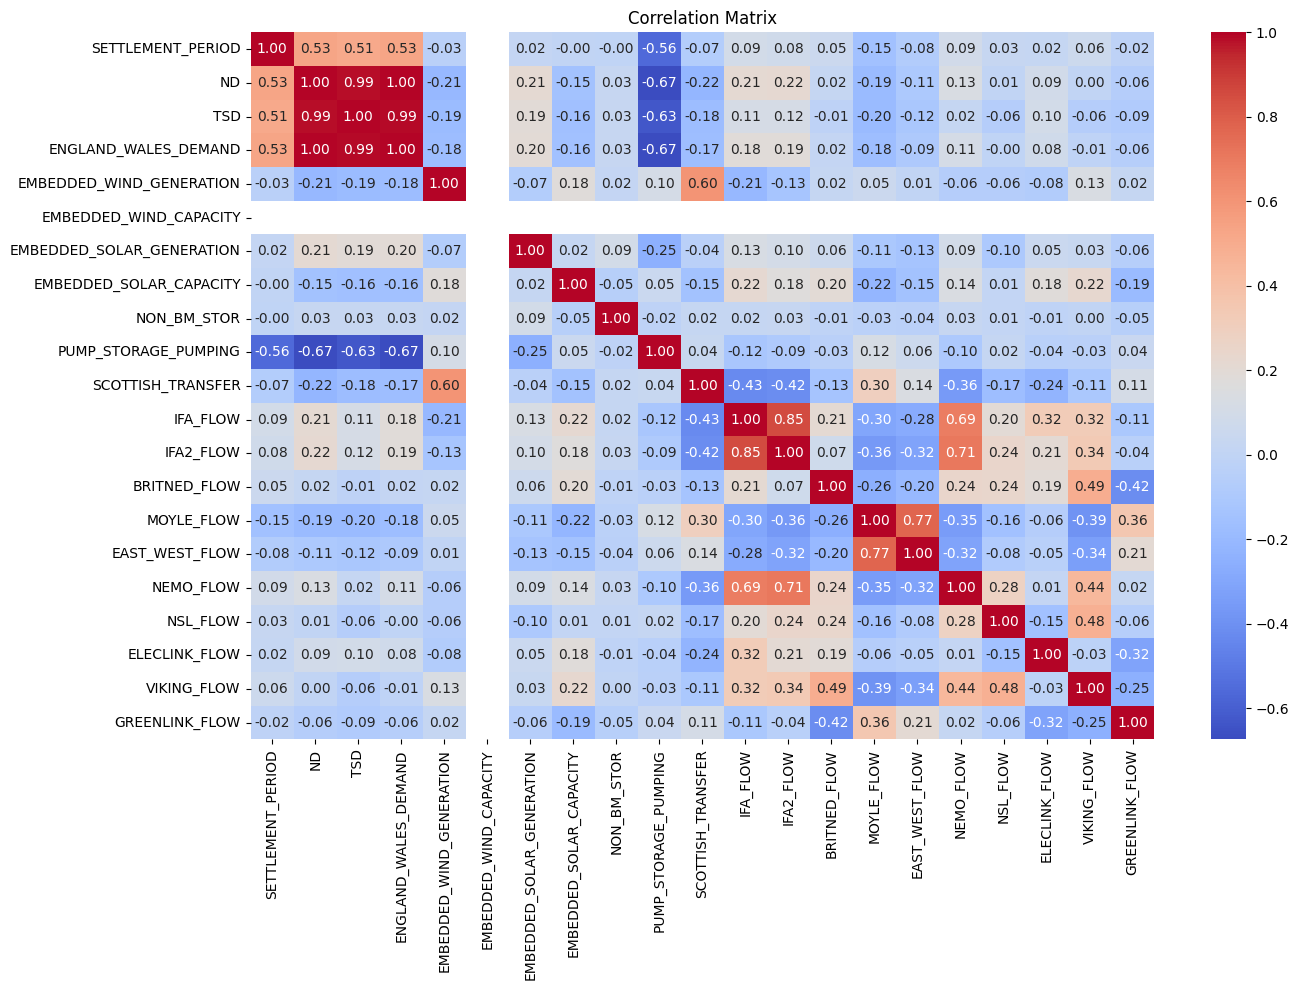

In [8]:
# Select only numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

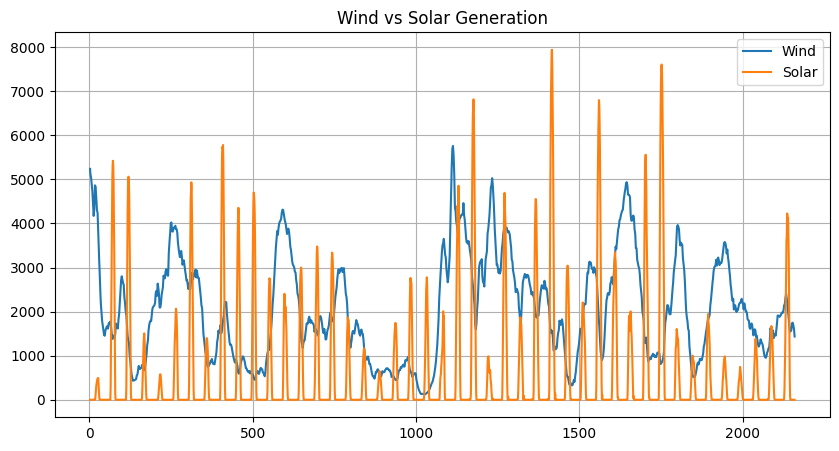

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df['EMBEDDED_WIND_GENERATION'], label='Wind')
plt.plot(df['EMBEDDED_SOLAR_GENERATION'], label='Solar')
plt.title('Wind vs Solar Generation')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
target = 'ENGLAND_WALES_DEMAND'
features = df.drop(columns=[target])
X = features
y = df[target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, shuffle=False)
y_train_scaled, y_test_scaled = train_test_split(y_scaled, test_size=0.2, shuffle=False)

In [22]:
# Ensure X contains only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
rf_pred = rf.predict(X_test)

In [24]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [25]:
def create_sequences(X, y, timesteps=10):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

timesteps = 10
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, timesteps)
X_lstm_train, X_lstm_test = train_test_split(X_lstm, test_size=0.2, shuffle=False)
y_lstm_train, y_lstm_test = train_test_split(y_lstm, test_size=0.2, shuffle=False)

model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32, verbose=0)
lstm_pred = model_lstm.predict(X_lstm_test)

c:\Users\chowd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [26]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32, verbose=0)
cnn_pred = model_cnn.predict(X_lstm_test)

c:\Users\chowd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [27]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")
evaluate(y_lstm_test, lstm_pred, "LSTM")
evaluate(y_lstm_test, cnn_pred, "CNN")

Random Forest - MAE: 170.20, RMSE: 219.65
XGBoost - MAE: 185.43, RMSE: 245.11
LSTM - MAE: 0.07, RMSE: 0.08
CNN - MAE: 0.06, RMSE: 0.08


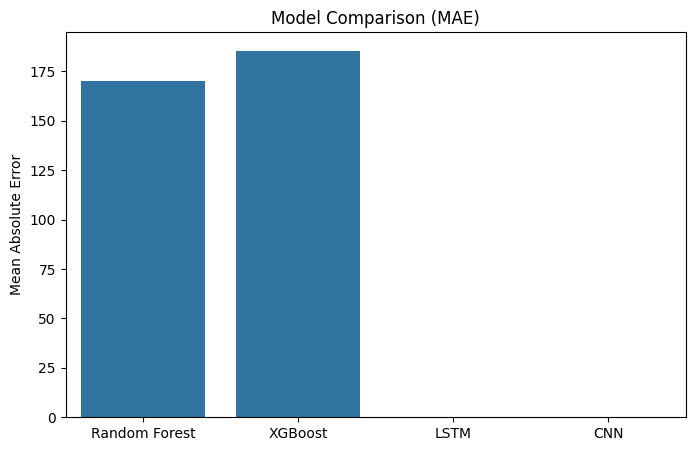

In [28]:
models = ['Random Forest', 'XGBoost', 'LSTM', 'CNN']
mae_scores = [
    mean_absolute_error(y_test, rf_pred),
    mean_absolute_error(y_test, xgb_pred),
    mean_absolute_error(y_lstm_test, lstm_pred),
    mean_absolute_error(y_lstm_test, cnn_pred)
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=mae_scores)
plt.title("Model Comparison (MAE)")
plt.ylabel("Mean Absolute Error")
plt.show()

In [31]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk

class ForecastApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Electricity Demand Forecasting")
        self.root.geometry("600x400")
        self.model_var = tk.StringVar()
        self.filename = None

        title = tk.Label(root, text="Electricity Demand Forecasting", font=("Helvetica", 16, "bold"))
        title.pack(pady=10)

        upload_btn = tk.Button(root, text="Upload Dataset", command=self.load_dataset)
        upload_btn.pack(pady=10)

        model_frame = tk.Frame(root)
        model_frame.pack(pady=10)
        tk.Label(model_frame, text="Choose Model: ").pack(side=tk.LEFT)

        model_options = ["LSTM", "CNN"]
        model_menu = ttk.Combobox(model_frame, textvariable=self.model_var, values=model_options, state="readonly")
        model_menu.set("Select")
        model_menu.pack(side=tk.LEFT)

        train_btn = tk.Button(root, text="Train and Predict", command=self.run_model)
        train_btn.pack(pady=10)

        self.result_text = tk.Text(root, height=10, width=70)
        self.result_text.pack(pady=10)

    def load_dataset(self):
        self.filename = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if self.filename:
            messagebox.showinfo("File Selected", f"{self.filename} loaded successfully!")

    def run_model(self):
        if not self.filename or self.model_var.get() == "Select":
            messagebox.showwarning("Input Error", "Please upload a dataset and select a model.")
            return

        try:
            # Reload data from the selected file
            df = pd.read_csv(self.filename)
            df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])
            df['datetime'] = df['SETTLEMENT_DATE'] + pd.to_timedelta((df['SETTLEMENT_PERIOD'] - 1) * 30, unit='m')
            df.set_index('datetime', inplace=True)
            df.drop(columns=['SETTLEMENT_DATE'], inplace=True)
            df.fillna(method='ffill', inplace=True)

            target = 'ENGLAND_WALES_DEMAND'
            features = df.drop(columns=[target])
            X = features
            y = df[target]

            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X)
            y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
            X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, shuffle=False)
            y_train_scaled, y_test_scaled = train_test_split(y_scaled, test_size=0.2, shuffle=False)

            model_name = self.model_var.get()
            result = ""

            if model_name == "Random Forest":
                rf = RandomForestRegressor(n_estimators=100, random_state=42)
                rf.fit(X_train, y_train)
                pred = rf.predict(X_test)
                result = self.evaluate(y_test, pred, "Random Forest")

            elif model_name == "XGBoost":
                xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
                xgb.fit(X_train, y_train)
                pred = xgb.predict(X_test)
                result = self.evaluate(y_test, pred, "XGBoost")

            elif model_name == "LSTM":
                X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, 10)
                X_lstm_train, X_lstm_test = train_test_split(X_lstm, test_size=0.2, shuffle=False)
                y_lstm_train, y_lstm_test = train_test_split(y_lstm, test_size=0.2, shuffle=False)

                model_lstm = Sequential([
                    LSTM(64, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
                    Dense(1)
                ])
                model_lstm.compile(optimizer='adam', loss='mse')
                model_lstm.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32, verbose=0)
                pred = model_lstm.predict(X_lstm_test)
                result = self.evaluate(y_lstm_test, pred, "LSTM")

            elif model_name == "CNN":
                X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, 10)
                X_lstm_train, X_lstm_test = train_test_split(X_lstm, test_size=0.2, shuffle=False)
                y_lstm_train, y_lstm_test = train_test_split(y_lstm, test_size=0.2, shuffle=False)

                model_cnn = Sequential([
                    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
                    MaxPooling1D(pool_size=2),
                    Flatten(),
                    Dense(50, activation='relu'),
                    Dense(1)
                ])
                model_cnn.compile(optimizer='adam', loss='mse')
                model_cnn.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32, verbose=0)
                pred = model_cnn.predict(X_lstm_test)
                result = self.evaluate(y_lstm_test, pred, "CNN")

            self.result_text.delete("1.0", tk.END)
            self.result_text.insert(tk.END, result)

        except Exception as e:
            messagebox.showerror("Error", str(e))

    def evaluate(self, y_true, y_pred, model_name):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return f"{model_name} Results:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}"

def create_sequences(X, y, timesteps=10):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

if __name__ == "__main__":
    root = tk.Tk()
    app = ForecastApp(root)
    root.mainloop()